In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import k3d
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from utilis.resize_label import *
from utilis.callbacks import *
from utilis.utilis import *
from models.unet import *
from models.encoders.vgg_encoder import *

# Get data and labels

In [2]:
coord_data_dir = "/data/cornucopia/ib255/derivative_datasets/cued_scene_coordinate_regression/data_from_jason/DS_003_JDB-Full/coordinates/"

In [3]:
data_size = 1
images = np.zeros((data_size, 2048, 4096, 3), dtype=np.int16)
labels = np.zeros((data_size, 2048, 4096, 3), dtype=np.float32)


for data in range(1,data_size + 1):
    if data < 10:
        data = "00" + str(data)
    elif data < 100:
        data = "0" + str(data)

    coord_npz = "0{}_rendered.png_config.npz".format(str(data))
    npz_data = np.load(coord_data_dir + coord_npz)
    
    images[int(data)-1,:,:,:] = npz_data['image_colors']
    labels[int(data)-1,:,:,:] = npz_data['points_3d_camera']

# Let's downsample image and label to 224x224 size

In [4]:
images_low = np.zeros((data_size, 224, 224, 3), dtype=np.int16)
labels_low = np.zeros((data_size, 224, 224, 3), dtype=np.float32)

for ind in range(data_size):
    images_low[ind,:,:,:] = cv2.resize(images[ind,:,:,:],(224, 224), interpolation = cv2.INTER_CUBIC)
    
for ind in range(data_size):
    labels_low[ind,:,:,:] = resize_coordinates(labels[ind,:,:,:], new_dim=(224,224))

# Artificially increse size of the dataset for testing

In [7]:
# images_new = np.concatenate((images_low, images_low), axis=0)
# labels_new = np.concatenate((labels_low, labels_low), axis=0)

In [8]:
# images_new = np.concatenate((images_new, images_new), axis=0)
# labels_new = np.concatenate((labels_new, labels_new), axis=0)

In [9]:
# images_new.shape

# Write a simple model

In [111]:
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import k3d
import gc
import os


class RemoveGarbageCallback(keras.callbacks.Callback):
    " Clean garbage variables - hopefully this releases soem memory " 
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


class Visualise_learning(keras.callbacks.Callback):
    """
    Visualises fit of predicted 3D coords for a signle image passed (train_image)
    Saves a .png every "frequency" epochs

    TODO: 
    1) Current visualisation is very 2D. Would be nice to improve its meanigfulness.
    2) See if you can display figures online (integrate with TensorBoard?)    
    """
    def __init__(self, train_image, ground_truth, frequency, exp_name):
        super(Visualise_learning, self).__init__()
        self.train_image = train_image
        self.ground_truth = ground_truth
        self.frequency = frequency
        self.save_dir = '/home/mlmi-2020/jz522/localisation_from_image_project/experiments/' + exp_name + "/train_visualisations/"
        
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
    
    

    def plot_simple_3D_point_cloud(self, file_name, ground_truth, pred):
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')

        gt_xyz = ground_truth.reshape(-1, ground_truth.shape[-1])[::20]
        ax.scatter(gt_xyz[:,0], gt_xyz[:,1], gt_xyz[:,2], c='r', marker='o')

        pred_xyz = pred.reshape(-1, pred.shape[-1])[::20]
        ax.scatter(pred_xyz[:,0], pred_xyz[:,1], pred_xyz[:,2], c='b', marker='o')
        
        fig.savefig(self.save_dir + file_name)


        
    def plot_colored_3D_point_cloud(self, file_name, ground_truth, pred):
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')


        gt_xyz = ground_truth.reshape(-1, ground_truth.shape[-1])[::20]
        ax.scatter(gt_xyz[:,0], gt_xyz[:,1], gt_xyz[:,2], c='teal', marker='o', label='ground-truth')

        diff = np.abs(ground_truth - pred)
        diff_binary = np.mean(diff, axis=-1)[0]
        diff_binary = diff_binary.reshape(-1)[::20]
        bins = np.array([0.1,1,3])
        binarised = np.digitize(diff_binary, bins, right=False)
        
        pred_xyz = pred.reshape(-1, pred.shape[-1])[::20]

        colors = ['darkgreen', 'gold', 'tomato', 'darkred']#['darkgreen', 'limegreen', 'gold', 'darkred']
        color_labels = ['well', 'good', 'bad', 'wrong']
        for ind, color, label in zip(range(4),colors,color_labels):
            indexes = np.argwhere(binarised==ind)
            ax.scatter(pred_xyz[indexes,0], pred_xyz[indexes,1], pred_xyz[indexes,2], c=color, marker='o', label=label) #RGB
        fig.legend(fontsize=20)
        fig.savefig(self.save_dir + file_name)


    def plot_pixelwise_coordinate_accuracy(self, file_name, ground_truth, pred):
        """ compute cordinate wise difference  """
        cord_range = np.max(ground_truth) - np.min(ground_truth)

        diff = np.abs(ground_truth - pred)
        diff_binary = np.mean(diff, axis=-1)[0]
        bins = np.array([0.1,1,3])
        binarised = np.digitize(diff_binary, bins, right=False)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
        
        # LEFT PLOT - shows pixelwise error
        im1 = ax1.imshow(diff_binary, cmap='Greys', vmin=0, vmax=6)
        divider = make_axes_locatable(ax1)
        cax1 = divider.append_axes('right', size='5%', pad=0.1)
        cbar1 = fig.colorbar(im1, cax=cax1)
        ax1.set_title('Pixelwise residual error [gt - pred]')
        cbar1.ax.set_yticklabels(['0','1','2','3','4','5','6+']) 

        # RIGHT PLOT - projection of 3D scatter plot
        im2 = ax2.imshow(binarised, cmap=plt.cm.get_cmap('RdYlGn_r', 4), vmin=-0.5, vmax=3.5)
        divider = make_axes_locatable(ax2)
        cax2 = divider.append_axes('right', size='5%', pad=0.1)
        cbar2 = fig.colorbar(im2, cax=cax2, ticks=[0,1,2,3])
        ax2.set_title('Pixelwise residual error - buckets')
        cbar2.ax.set_yticklabels(['< 0.1', '< 1', '< 3', '3+']) 
        
        fig.savefig(self.save_dir + file_name)


        
    def writePlyFile(self, file_name, vertices, colors):
        ply_header = '''ply
                    format ascii 1.0
                    element vertex %(vert_num)d
                    property float x
                    property float y
                    property float z
                    property uchar red
                    property uchar green
                    property uchar blue
                    end_header
                '''
        vertices = vertices.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        vertices = np.hstack([vertices, colors])
        with open(self.save_dir + file_name + '.ply', 'w') as f:
            f.write(ply_header % dict(vert_num=len(vertices)))
            np.savetxt(f, vertices, '%f %f %f %d %d %d')


            
    def on_epoch_end(self, epoch, logs=None):
        if(epoch%self.frequency == 0):
            train_x = np.expand_dims(self.train_image, axis=0)
            pred_coordinates = self.model.predict(train_x)
            
            # plot 3D point convergence
            simple_vis_file = "simple_vis_" + str(epoch) 
            # self.plot_simple_3D_point_cloud(simple_vis_file, self.ground_truth, pred_coordinates)
            self.plot_colored_3D_point_cloud(simple_vis_file, self.ground_truth, pred_coordinates)

            # plot pixel wise accuracy
            pixelwise_acc_file = "pixelwise_accuracy_" + str(epoch) 
            self.plot_pixelwise_coordinate_accuracy(pixelwise_acc_file, self.ground_truth, pred_coordinates)

            # save .ply file for visualisation
            ply_file = "scene_coordinates_" + str(epoch) 
            self.writePlyFile(ply_file, pred_coordinates, self.train_image)


### single gpu

In [112]:
compile_configs = {'metrics': [keras.metrics.MeanAbsoluteError()]}

unet_model = vgg_unet()
unet_model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), **compile_configs)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 4.5580 - mean_absolute_error: 1.5510

/home/mlmi-2020/jz522/localisation_from_image_project/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator


1/1 [==============================] - 2s 2s/step - loss: 4.5580 - mean_absolute_error: 1.5510
Epoch 2/100
1/1 [==============================] - 0s 258ms/step - loss: 3.0506 - mean_absolute_error: 1.3163
Epoch 3/100
1/1 [==============================] - 0s 230ms/step - loss: 2.5342 - mean_absolute_error: 1.2056
Epoch 4/100
1/1 [==============================] - 0s 244ms/step - loss: 2.1969 - mean_absolute_error: 1.1170
Epoch 5/100
1/1 [==============================] - 0s 258ms/step - loss: 1.9138 - mean_absolute_error: 1.0417
Epoch 6/100
1/1 [==============================] - 0s 260ms/step - loss: 1.6688 - mean_absolute_error: 0.9752
Epoch 7/100
1/1 [==============================] - 0s 222ms/step - loss: 1.4712 - mean_absolute_error: 0.9172
Epoch 8/100
1/1 [==============================] - 0s 238ms/step - loss: 1.3027 - mean_absolute_error: 0.8623
Epoch 9/100
1/1 [==============================] - 0s 226ms/step - loss: 1.1701 - mean_absolute_error: 0.8121
Epoch 10/100
1/1 [=======

1/1 [==============================] - 0s 252ms/step - loss: 0.0616 - mean_absolute_error: 0.1755
Epoch 76/100
1/1 [==============================] - 0s 245ms/step - loss: 0.0609 - mean_absolute_error: 0.1755
Epoch 77/100
1/1 [==============================] - 0s 245ms/step - loss: 0.0604 - mean_absolute_error: 0.1736
Epoch 78/100
1/1 [==============================] - 0s 267ms/step - loss: 0.0597 - mean_absolute_error: 0.1741
Epoch 79/100
1/1 [==============================] - 0s 270ms/step - loss: 0.0582 - mean_absolute_error: 0.1701
Epoch 80/100
1/1 [==============================] - 0s 262ms/step - loss: 0.0572 - mean_absolute_error: 0.1687
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.0568 - mean_absolute_error: 0.1690
Epoch 82/100
1/1 [==============================] - 0s 257ms/step - loss: 0.0558 - mean_absolute_error: 0.1662
Epoch 83/100
1/1 [==============================] - 0s 282ms/step - loss: 0.0548 - mean_absolute_error: 0.1650
Epoch 84/100
1/1 

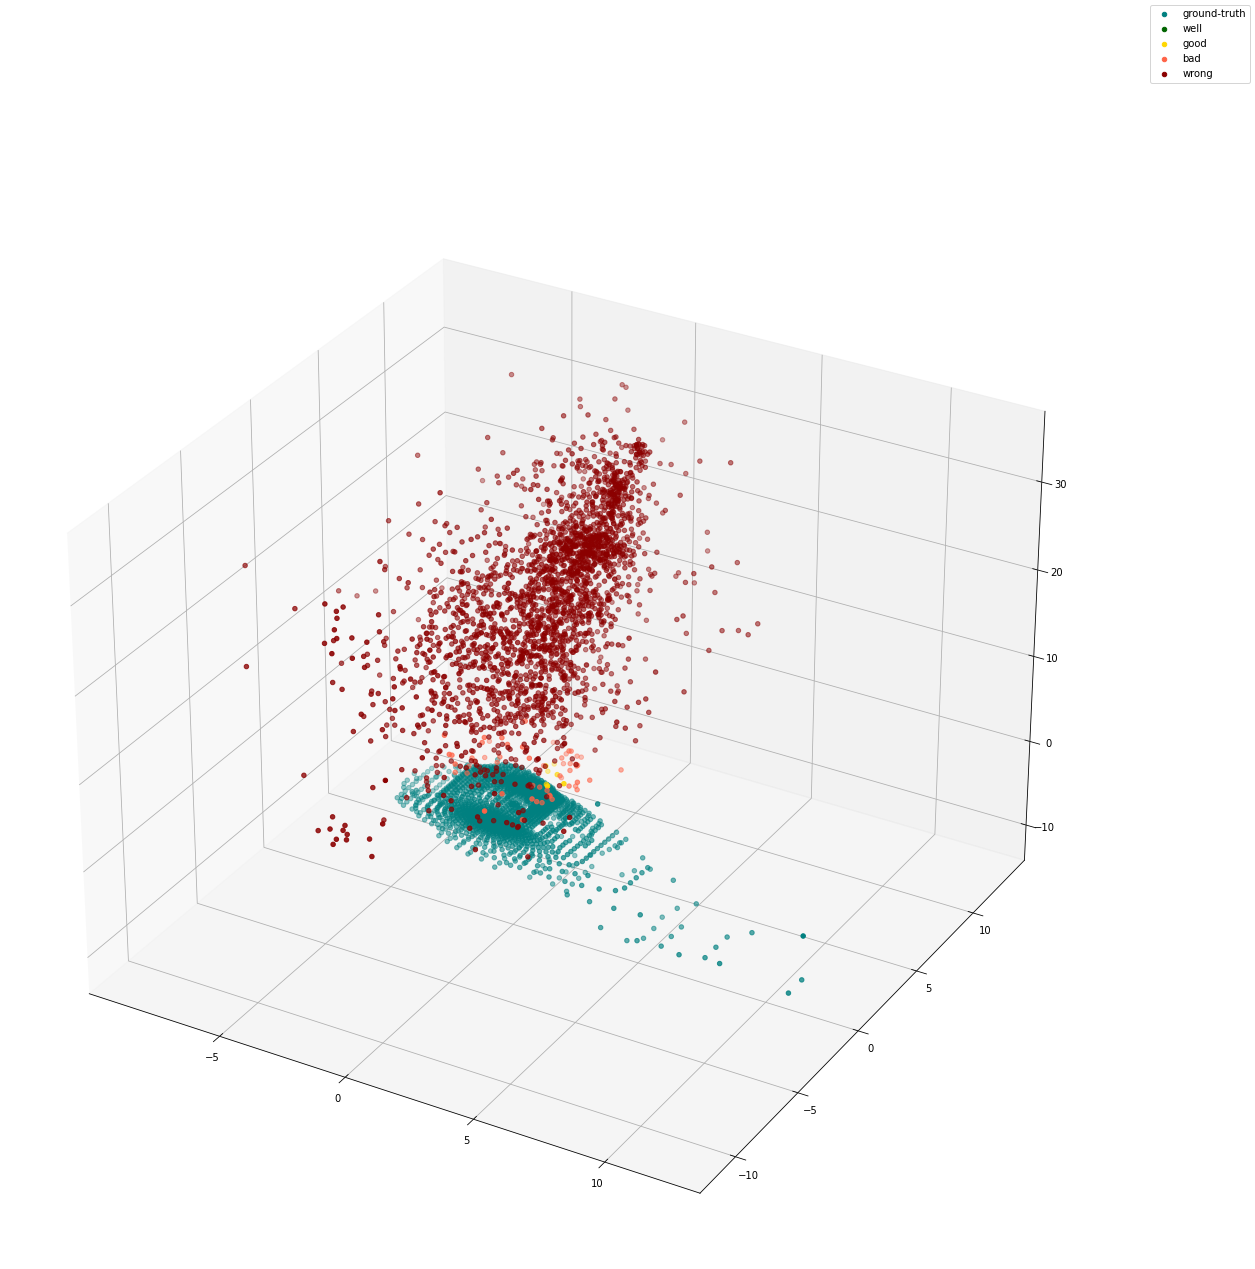

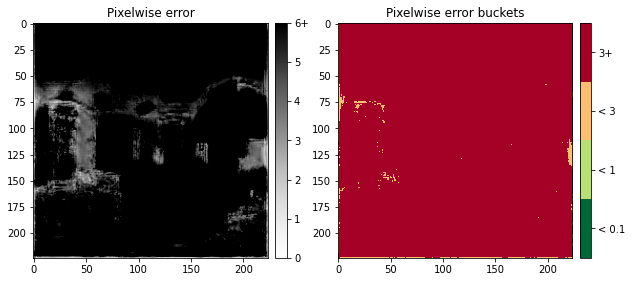

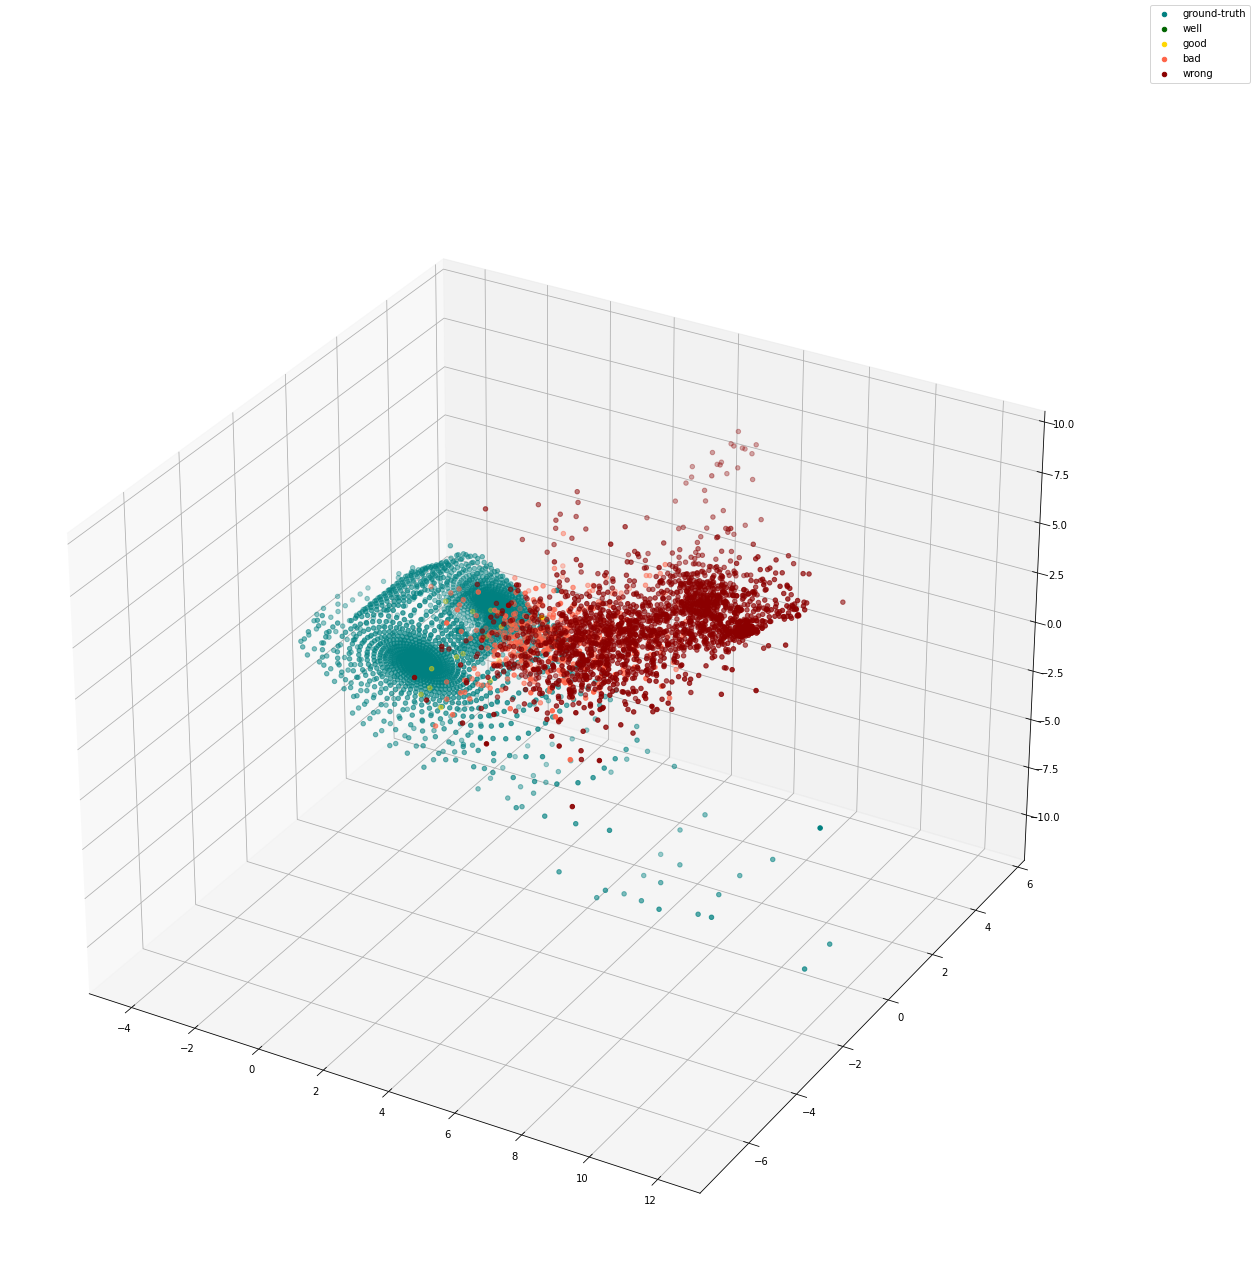

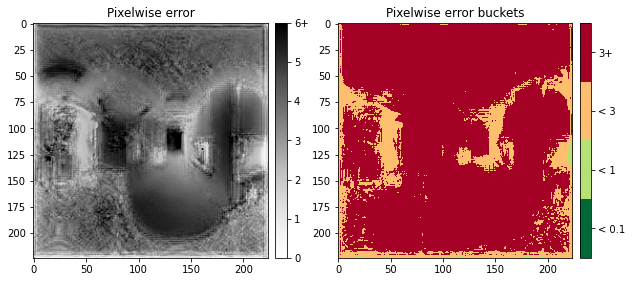

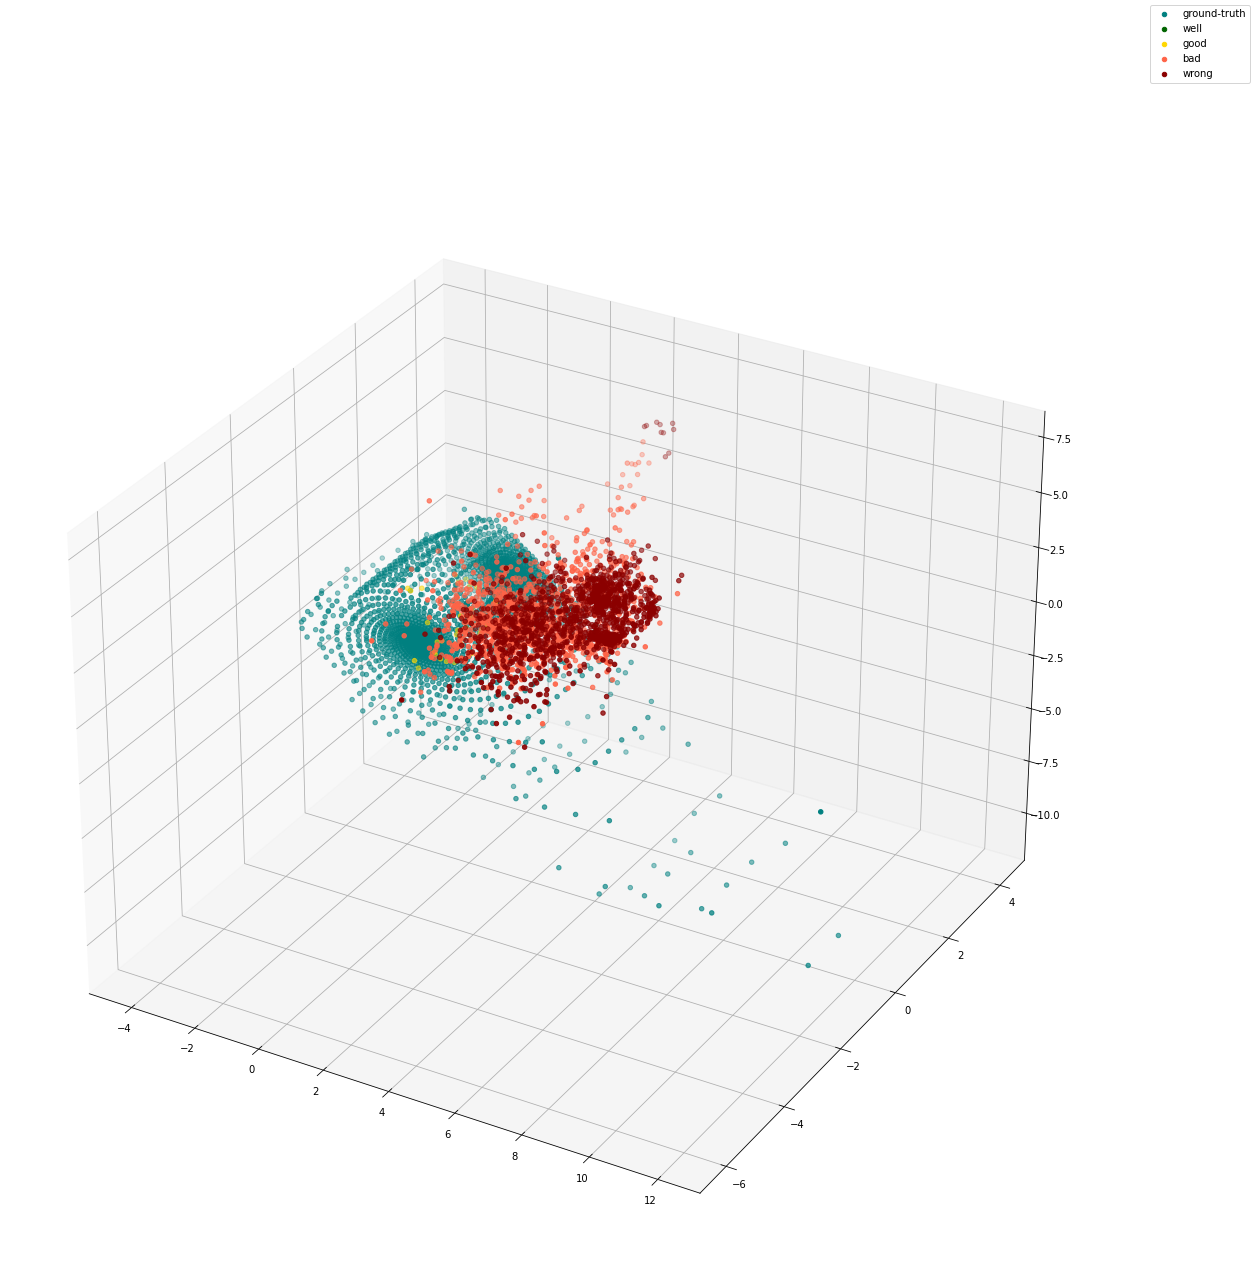

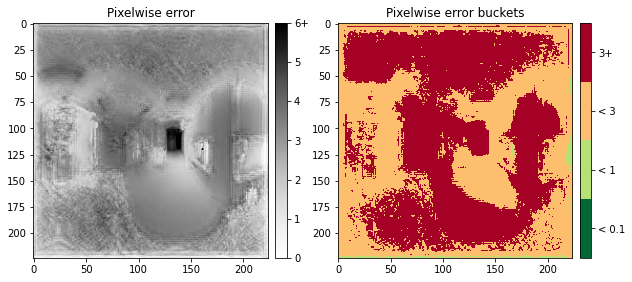

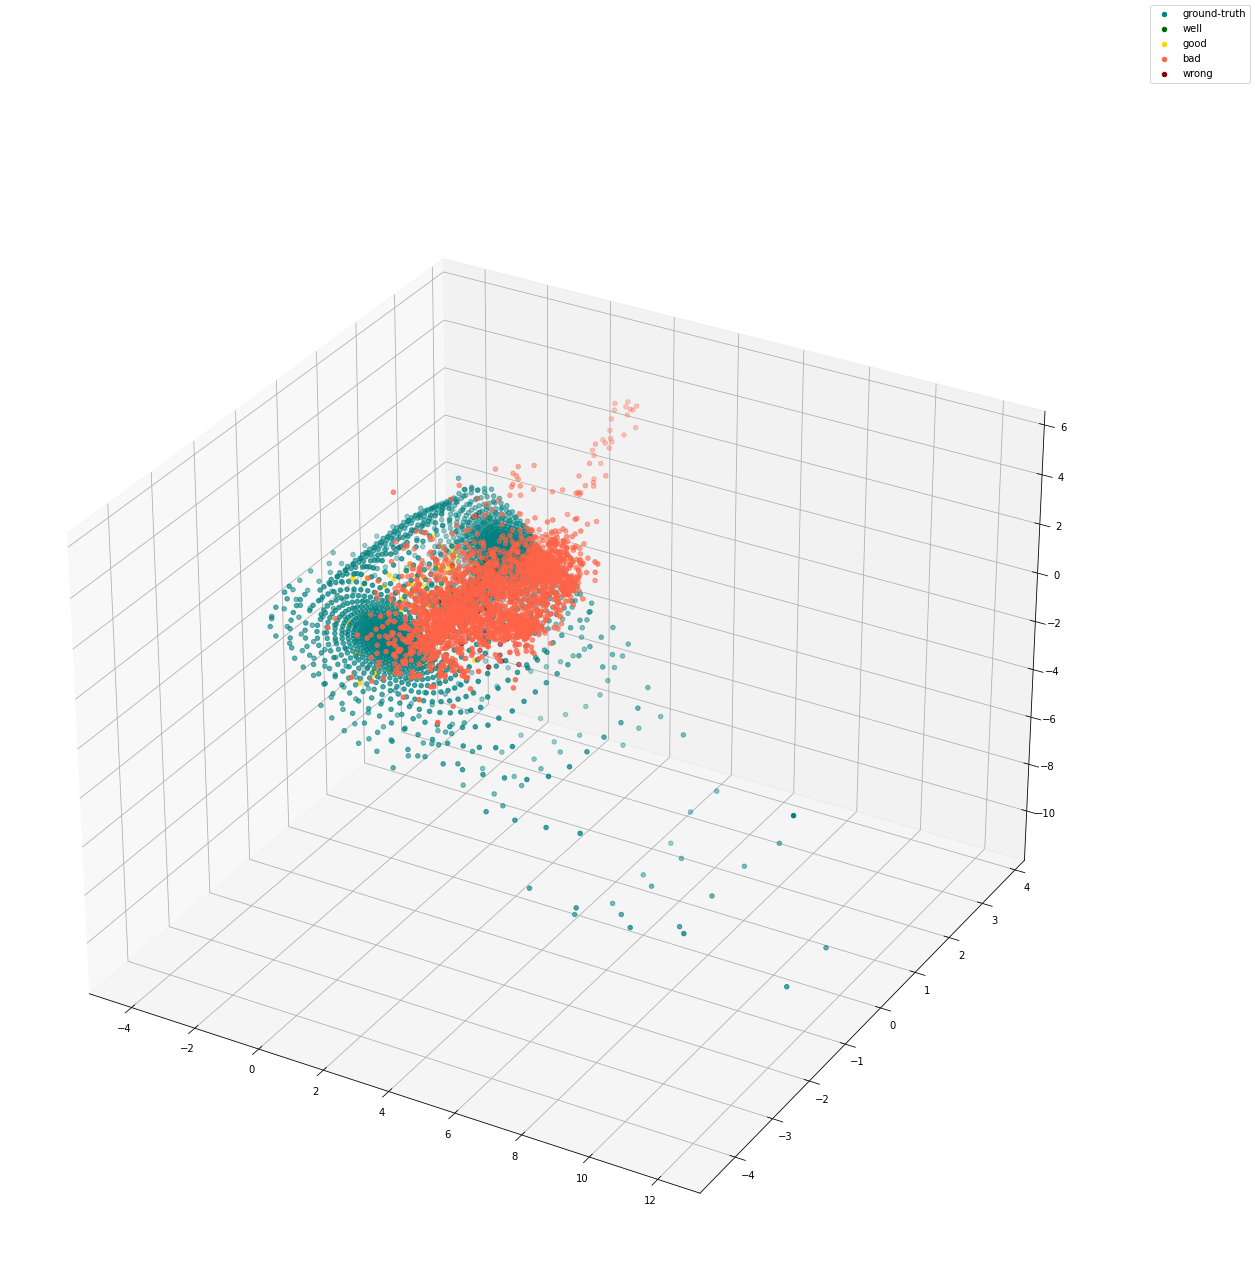

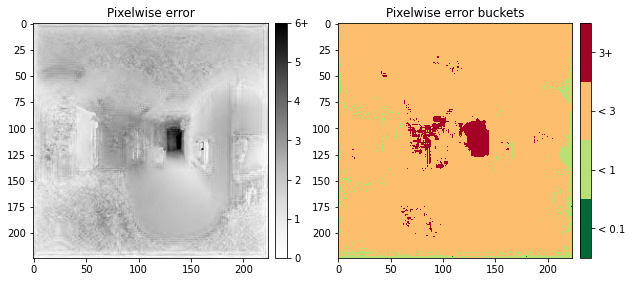

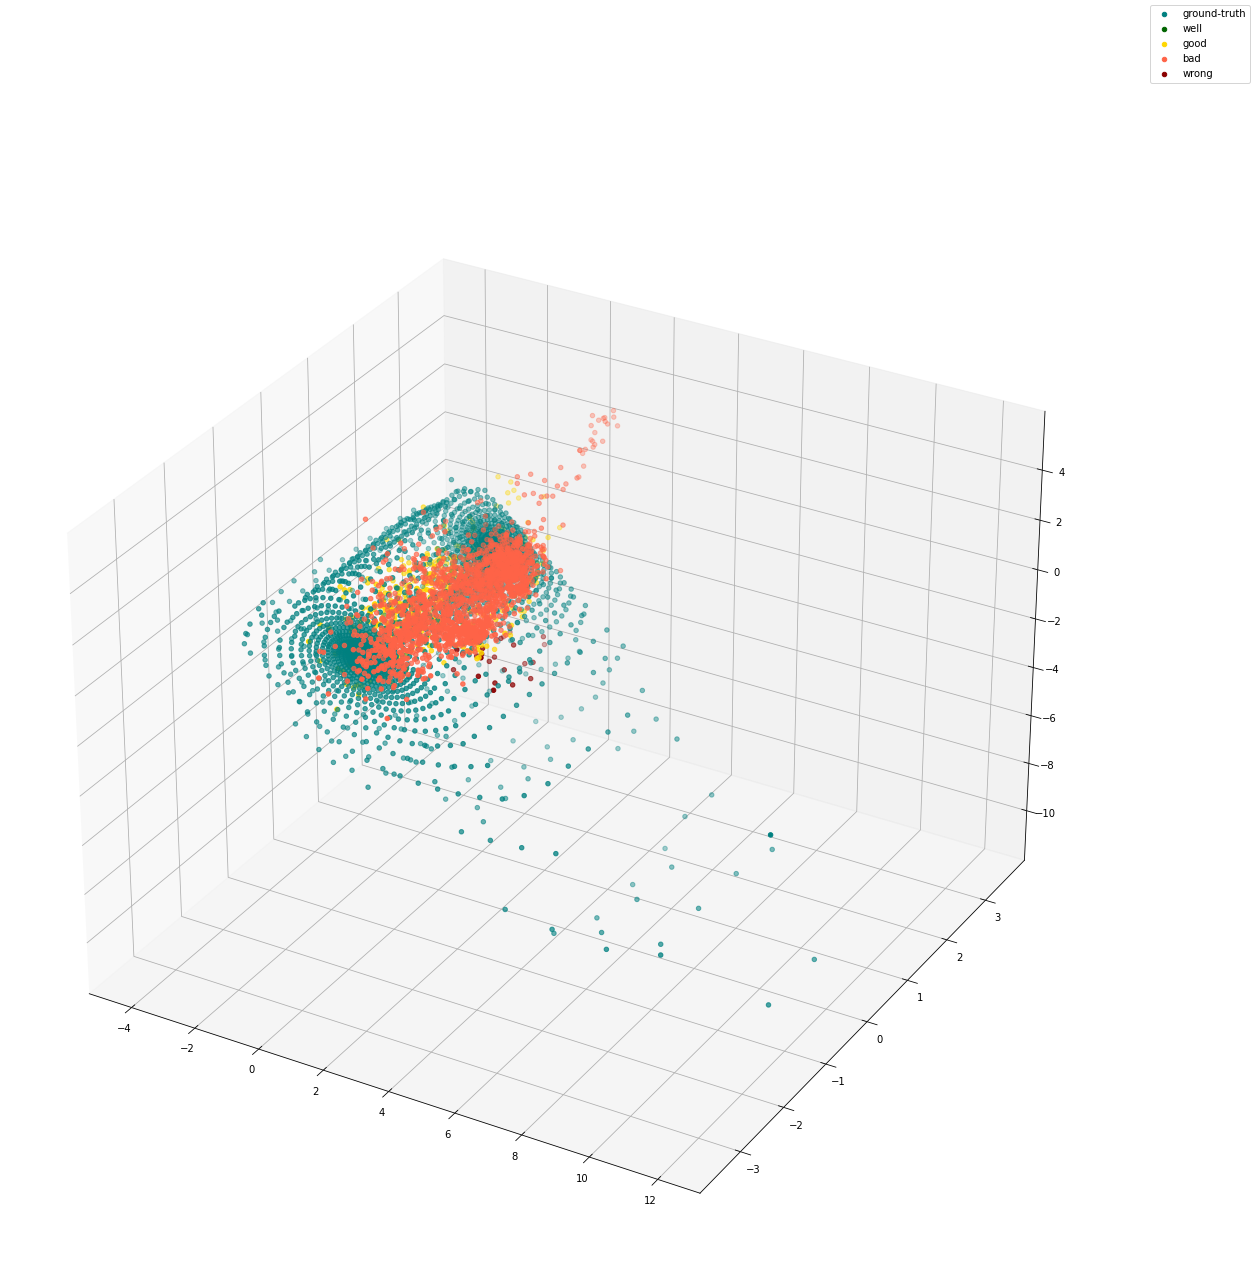

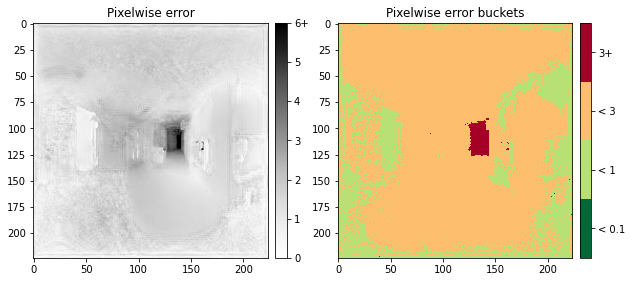

In [113]:
fit_configs = {'callbacks': [RemoveGarbageCallback(),
                             Visualise_learning(images_low[0], labels_low[0], 20, "testing_callbacks")
                                              ],
#                'batch_size': 128,
               'epochs': 100,
               'verbose': 1}

unet_model.fit(x=images_low, y=labels_low, **fit_configs)

### multiple gpu

In [23]:
get_available_gpus()

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4',
 '/device:GPU:5',
 '/device:GPU:6',
 '/device:GPU:7']

In [29]:
# def vgg_unet(input_height=224, input_width=224):

#     model = unet(vgg_encoder, input_height=input_height, input_width=input_width)
#     model.model_name = "vgg_unet"
    
#     return model

In [31]:
strategy = tf.distribute.MirroredStrategy(['/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    
    compile_configs = {'metrics': [keras.metrics.MeanAbsoluteError()]}
                   
    fit_configs = {'callbacks': [RemoveGarbaseCallback(),
    #                            Visualise_learning(images_low[0], labels_low[0]
                                                  ],
                   'batch_size': 128,
                   'epochs': 5,
                   'verbose': 1}
    
    unet_model = vgg_unet()
    unet_model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001), **compile_configs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')
Number of devices: 4


In [32]:
unet_model.fit(x=images_new, y=labels_new, **fit_configs)

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
4/4 [==============================] - 2s 432ms/step - loss: 3.1559 - mean_absolute_error: 1.2825
Epoch 2/5
4/4 [==============================] - 2s 422ms/step - loss: 1.3058 - mean_absolute_error: 0.8429
Epoch 3/5
4/4 [==============================] - 2s 451ms/step - loss: 0.7855 - mean_absolute_error: 0.6390
Epoch 4/5
4/4 [==============================] - 2s 468ms/step - loss: 0.5099 - mean_absolute_error: 0.5173
Epoch 5/5
4/4 [==============================] - 2s 447ms/step - loss: 0.3681 - mean_absolute_error: 0.4432


In [33]:
del unet_model

In [62]:
pred_y = unet_model.predict(images_low)

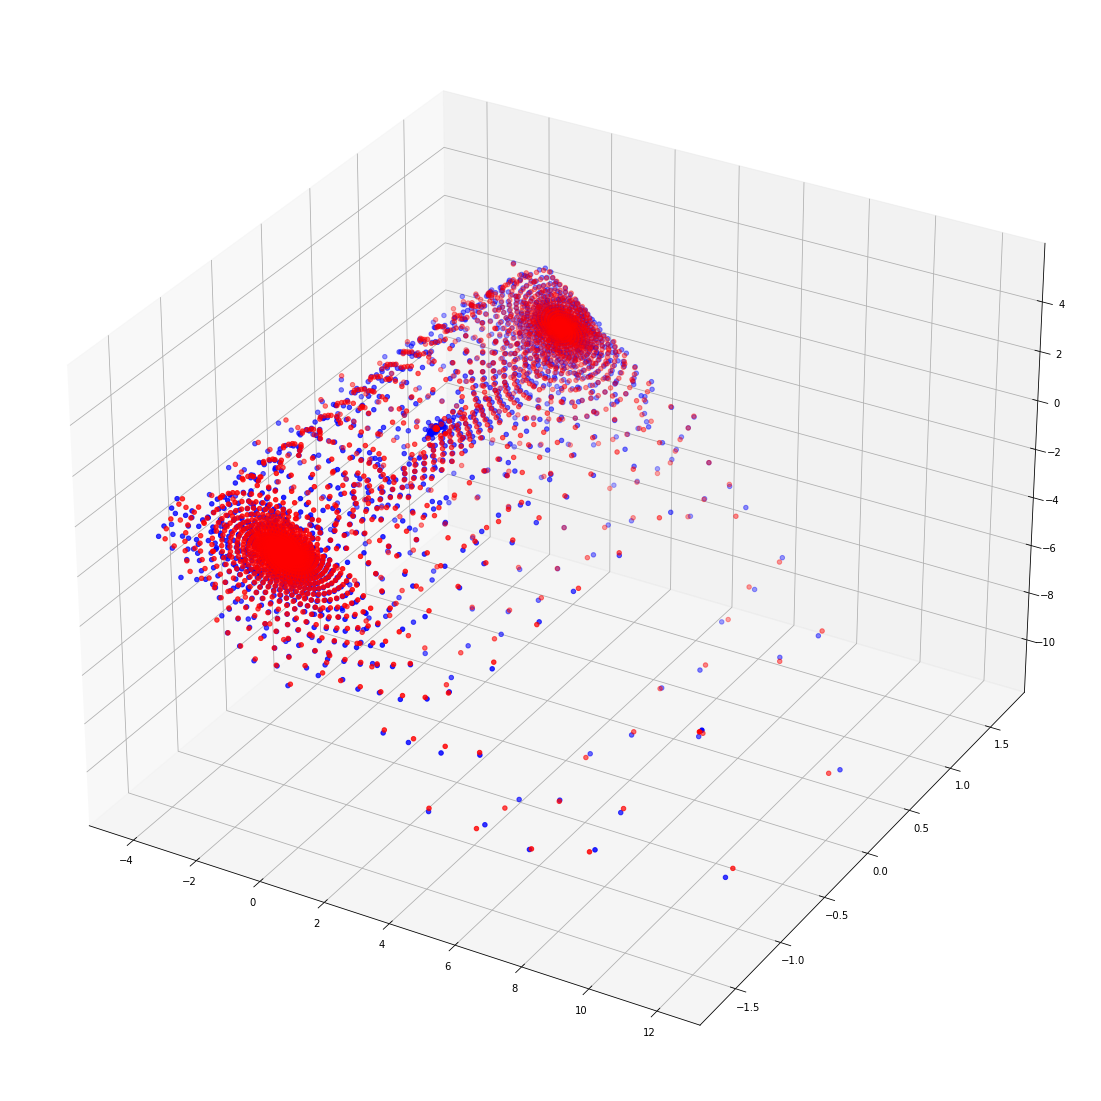

In [103]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

xyz = labels_low[0,:,:,:].reshape(-1, labels_low[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='r', marker='o')

xyz = pred_y[0,:,:,:].reshape(-1, pred_y[0,:,:,:].shape[-1])[::20]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='b', marker='o')

In [92]:
plot = k3d.plot(name='points')
plt_points = k3d.points(positions=labels_low[2], point_size=0.2, color=0xff0000, alpha=0.5)
plot += plt_points
plt_points = k3d.points(positions=pred_y[2], point_size=0.2, color=0x0000ff, alpha=0.5)
plot += plt_points
plt_points.shader='3d'
plot.display()

Output()

In [93]:
plot.fetch_screenshot()

In [94]:
with open('screenshot.png', 'wb') as f:
#     try:
#         out = plot.screenshot.decode('base64')
#     except: # Python 3
    from base64 import b64decode
    out = b64decode(plot.screenshot)    
    f.write(out)
    
Image(url='screenshot.png')

In [82]:
plot.screenshot

''

In [75]:
image_dir = plot.screenshot
img = mpimg.imread(image_dir)
plt.imshow(img)

AttributeError: 'str' object has no attribute 'read'

TypeError: Image data of dtype <U1 cannot be converted to float

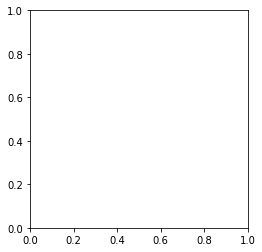

In [69]:
plt.imshow(plot.screenshot)